## Final Project: N-body Simulation
### Siyu-Rain Chen
##### 2024.11.29

In [1]:
# Python
from datetime import datetime

# MPL
import matplotlib        as mpl
import matplotlib.pyplot as plt

# NumPy
import numpy as np
from numpy import cos, exp, log, pi, sin, sqrt
from numpy.random import default_rng

# Scipy
import scipy.linalg as linalg
from scipy.fft import*

### Initial Conditions

In [2]:
# input initial conditions:
L = 1 # m
Rs = L/4 # m
Np = 8 ** 3 # # of particles
m_p = 1 # kg
part = np.zeros((Np, 9, 21)) # position * 3 (0-2); acceleration * 3 (3-5); velocity * 3 (6-8)
pos_initial = np.zeros((Np, 3)) # position
rng = np.random.default_rng(seed=42) # seed
plotRealTime = True

# Generate random numbers for spherical coordinates:
r = Rs * np.cbrt(rng.uniform(0, 1, Np))
phi = rng.uniform(0, 2 * np.pi, Np)
theta = np.arccos(1 - 2 * rng.uniform(0, 1, Np))

# Convert the spherical coordinates to Cartesian:
x = r * np.sin(theta) * np.cos(phi) + L/2
y = r * np.sin(theta) * np.sin(phi) + L/2 
z = r * np.cos(theta) + L/2

# Add position coordinates: 
pos_initial[:, 0], pos_initial[:, 1], pos_initial[:, 2] = x, y, z

# Print something:
print('The initial conditions is setted.')

The initial conditions is setted.


### Density Field

In [3]:
# Input data:
Nc = 128 # cells per side length
l = L / Nc # length for each cubical cell

def density_field(pos):
    density = np.zeros((Nc, Nc, Nc))

    for part in range(Np):
        x, y, z = pos[part,0], pos[part,1], pos[part,2]

        # grids that contain particles:
        i, j, k = int(x / l) % Nc, int(y / l) % Nc, int(z / l) % Nc

        # Number of overlaps:
        dx, dy, dz = (x / l) - i, (y / l) - j, (z / l) - k

        # Weight:
        weights = [(1 - dx) * (1 - dy) * (1 - dz), dx * (1 - dy) * (1 - dz), (1 - dx) * dy * (1 - dz), dx * dy * (1 - dz), 
            (1 - dx) * (1 - dy) * dz, dx * (1 - dy) * dz, (1 - dx) * dy * dz, dx * dy * dz] # 8 in total
        
        # Update density grid:
        for di, dj, dk, w in zip(
            [0, 1, 0, 1, 0, 1, 0, 1],  # x direction
            [0, 0, 1, 1, 0, 0, 1, 1],  # y direction
            [0, 0, 0, 0, 1, 1, 1, 1],  # z direction
            weights
        ):
            density[(i + di) % Nc, (j + dj) % Nc, (k + dk) % Nc] += m_p * w

    # Normalization:
    density /= l**3

    return density

# check 
density = density_field(pos_initial)
mass = density.sum() * l**3
if int(mass - Np * m_p) == 0:
    print("The density is correct.")
else:
    print("Wrong!")

The density is correct.


### Potential Field

In [4]:
# Input data:
G = 6.67430e-11  # m^3 kg^-1 s^-2
Nk = Nc

def potential_field(density):
    phi_k = np.zeros((Nk, Nk, Nk//2 + 1), dtype = complex)

    # FFT for the density field:
    rho_k = np.fft.rfftn(density)
    
    for i in range(Nk):
        for j in range(Nk):
            for k in range(Nk//2 + 1):
                if i <= Nk/2:
                    kx = 2 * np.pi / Nc * i
                else:
                    kx = 2 * np.pi / Nc * (i - Nk)                
                if j <= Nk/2:
                    ky = 2 * np.pi / Nc * j
                else:
                    ky = 2 * np.pi / Nc * (j - Nk)
                if k <= Nk/2:             
                    kz = 2 * np.pi / Nc * k
                else: 
                     kz = 2 * np.pi / Nc * (k - Nk)

                D = ((2 * np.sin(kx/2))**2 + (2 * np.sin(ky/2))**2 + (2 * np.sin(kz/2))**2 + 1e-9)
                factor = L / Nc # factor due to the normalization of FFt
                omega_k = - (4 * np.pi * G) / D 

                phi_k[i, j, k] = omega_k * rho_k[i,j,k] * factor

    # Inverse FFT for the potential field:
    phi= np.fft.irfftn(phi_k)

    return phi

### Particle Acceleration

##### Force on each axis:

In [5]:
# This one is definetely not correct. Still trying to fix it. 😭
def cal_force(phi):
    # Initialize for the force matrix:
    Fx = np.zeros((Nc, Nc, Nc))
    Fy = np.zeros((Nc, Nc, Nc))
    Fz = np.zeros((Nc, Nc, Nc))
    F = np.zeros((Nc, Nc, Nc, 3))

    # Computation for the force:
    # Fx: 
    for i in range(Nc):
        if i == 0: 
            Fx[i, :, :] = -(phi[i+1, :, :] - phi[i, :, :]) / l
        if i == Nc - 1:
            Fx[i, :, :] = -(phi[i, :, :] - phi[i-1, :, :]) / l
        else:
            Fx[i, :, :] = -(phi[i+1, :, :] - phi[i-1, :, :]) / (2*l)
    # Fy:
    for j in range(Nc):
        if j == 0: 
            Fy[:, j, :] = -(phi[:, j+1, :] - phi[:, j, :]) / l
        if j == Nc - 1:
            Fy[:, j, :] = -(phi[:, j, :] - phi[:, j-1, :]) / l
        else:
            Fy[:, j, :] = -(phi[:, j+1, :] - phi[:, j-1, :]) / (2*l)

    # Fz:
    for k in range(Nc):
        if k == 0: 
            Fz[:, :, k] = -(phi[:, :, k+1] - phi[:, :, k]) / l
        if k == Nc - 1:
            Fz[:, :, k] = -(phi[:, :, k] - phi[:, :, k-1]) / l
        else:
            Fz[:, :, k] = -(phi[:, :, k+1] - phi[:, :, k-1]) / (2*l)
    
    F[:,:,:,0] = Fx
    F[:,:,:,1] = Fy
    F[:,:,:,2] = Fz

    return F

##### Acceleration on each axis:

In [6]:
# With bug version: trying to figure this out.
def cal_acc(F, pos):
    # Initialize particle accelerations
    acceleration = np.zeros((Np, 3))
    Fx, Fy, Fz = F[:,:,:,0], F[:,:,:,1], F[:,:,:,2]

    # Iteration:
    for i in range(Np):
        x, y, z = pos[i, 0], pos[i, 1], pos[i, 2]

        # Grid Cell: 
        i1, j1, k1 = int(x // l), int(y // l), int(z // l)

        # Overlaps
        dx, dy, dz = (x / l) - i1, (y / l) - j1, (z / l) - k1
        
        # Weight:
        weights = [(1 - dx) * (1 - dy) * (1 - dz), dx * (1 - dy) * (1 - dz), (1 - dx) * dy * (1 - dz), dx * dy * (1 - dz), 
            (1 - dx) * (1 - dy) * dz, dx * (1 - dy) * dz, (1 - dx) * dy * dz, dx * dy * dz] # 8 in total

        # Computation for acceleration: 
        for di, dj, dk, w in zip(
            [0, 1, 0, 1, 0, 1, 0, 1],  # x offsets
            [0, 0, 1, 1, 0, 0, 1, 1],  # y offsets
            [0, 0, 0, 0, 1, 1, 1, 1],  # z offsets
            weights
        ):
            ii, jj, kk = (i1 + di) % Nc, (j1 + dj) % Nc, (k1 + dk) % Nc
            acceleration[i, 0] += Fx[ii, jj, kk] * w
            acceleration[i, 1] += Fy[ii, jj, kk] * w
            acceleration[i, 2] += Fz[ii, jj, kk] * w

    return acceleration / l**3

In [7]:
# Cited from https://github.com/pmocz/nbody-python to check how should the simulation be done.

def getAcc( pos, mass, G, softening):
	# positions r = [x,y,z] for all particles
	x = pos[:,0:1]
	y = pos[:,1:2]
	z = pos[:,2:3]

	# matrix that stores all pairwise particle separations: r_j - r_i
	dx = x.T - x
	dy = y.T - y
	dz = z.T - z

	# matrix that stores 1/r^3 for all particle pairwise particle separations 
	inv_r3 = (dx**2 + dy**2 + dz**2 + softening**2)
	inv_r3[inv_r3>0] = inv_r3[inv_r3>0]**(-1.5)

	ax = G * (dx * inv_r3) @ mass
	ay = G * (dy * inv_r3) @ mass
	az = G * (dz * inv_r3) @ mass
	
	# pack together the acceleration components
	a = np.hstack((ax,ay,az))

	return a

### Results and Discussion

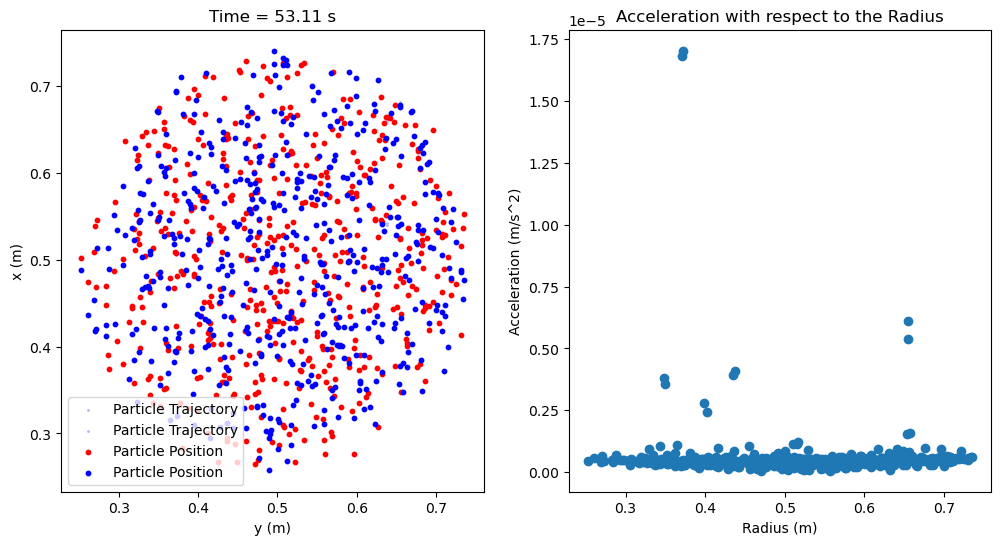

<Figure size 640x480 with 0 Axes>

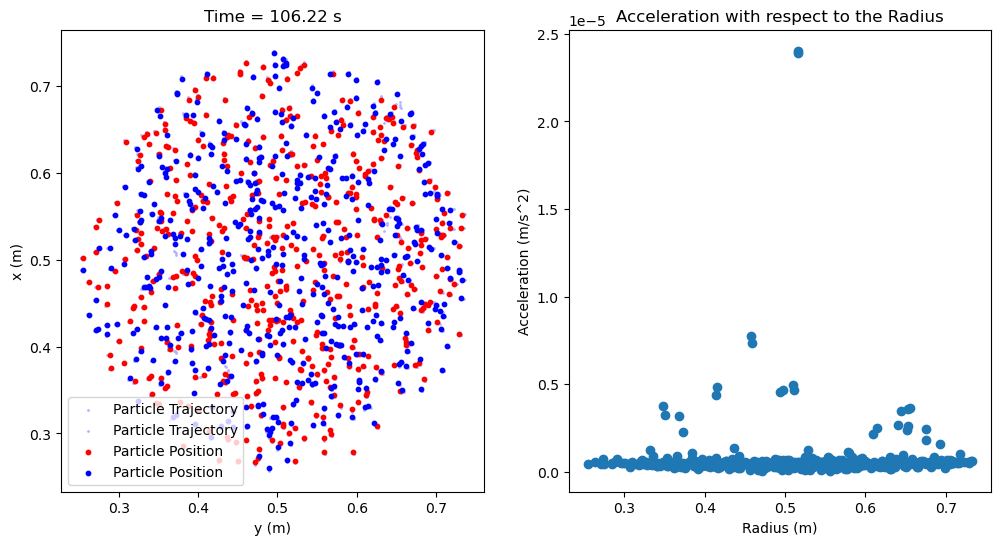

<Figure size 640x480 with 0 Axes>

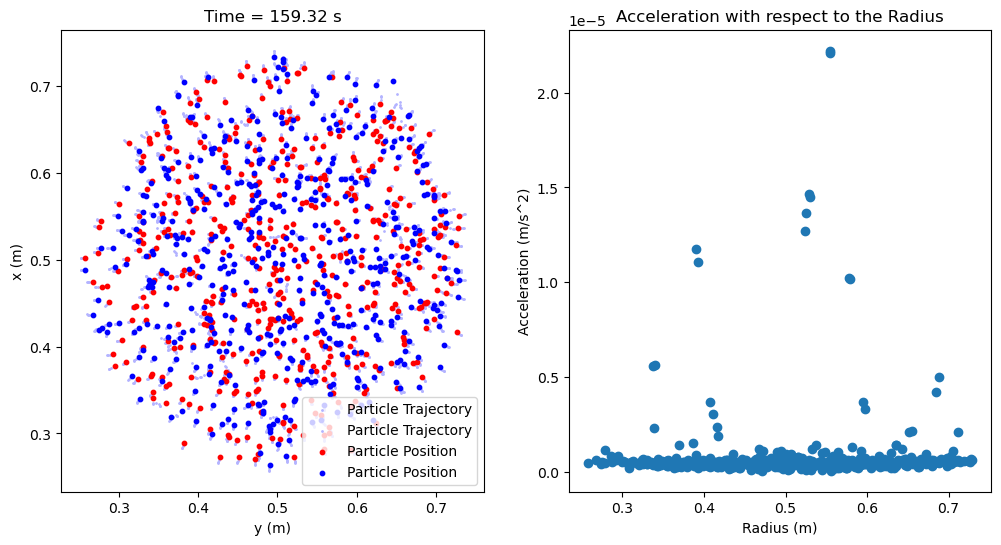

<Figure size 640x480 with 0 Axes>

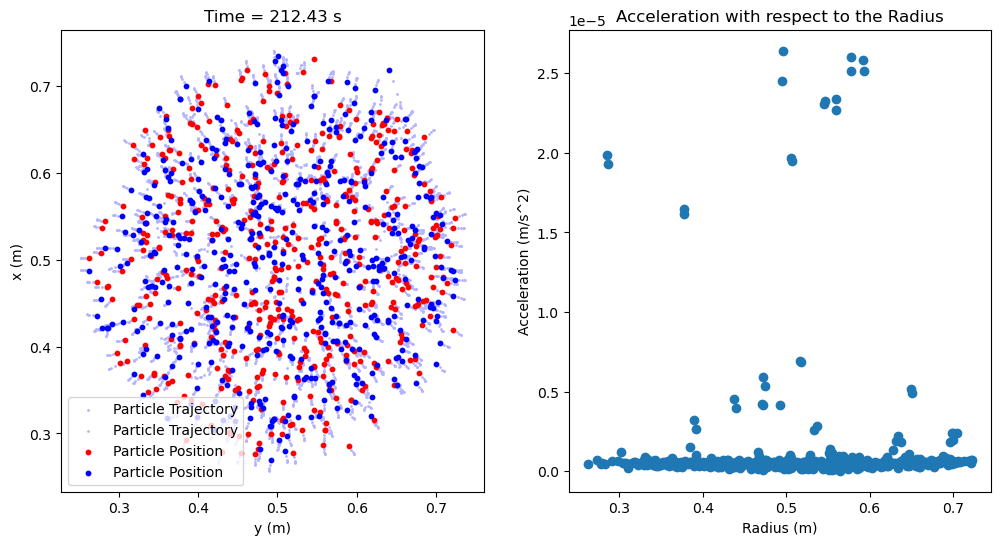

<Figure size 640x480 with 0 Axes>

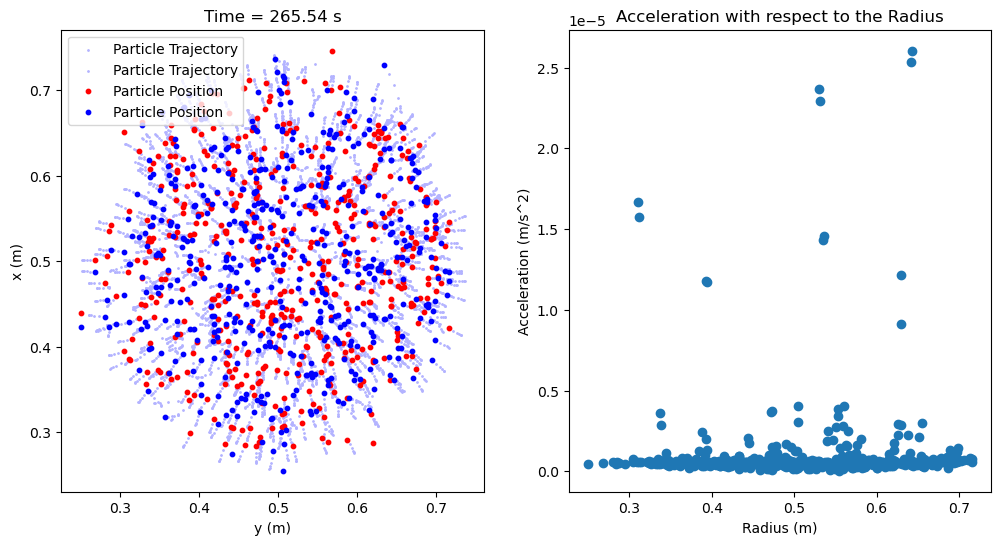

<Figure size 640x480 with 0 Axes>

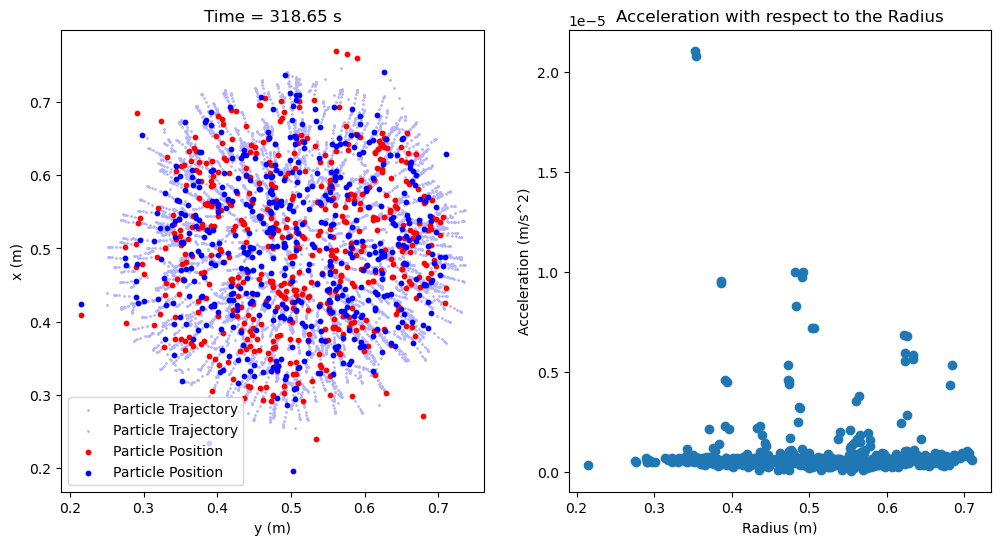

<Figure size 640x480 with 0 Axes>

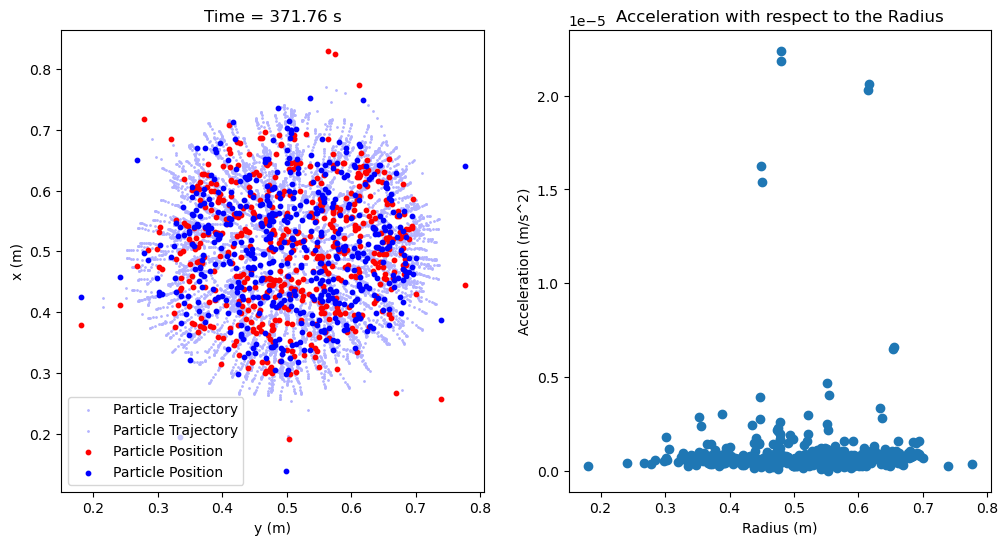

<Figure size 640x480 with 0 Axes>

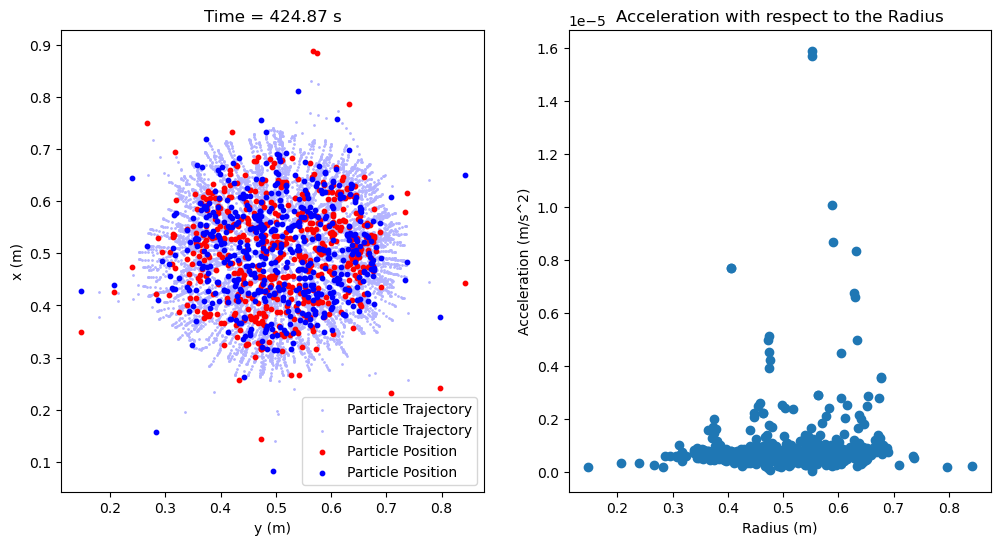

<Figure size 640x480 with 0 Axes>

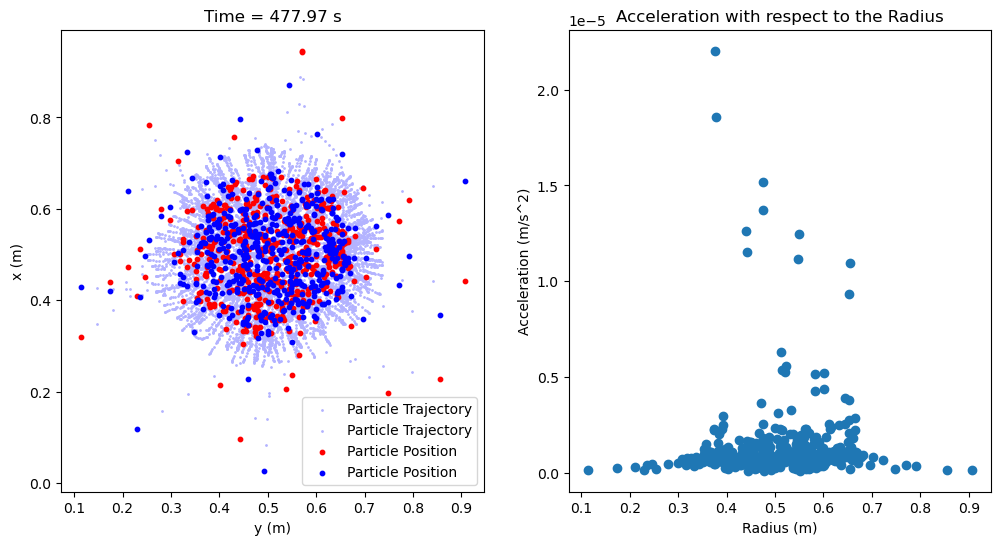

<Figure size 640x480 with 0 Axes>

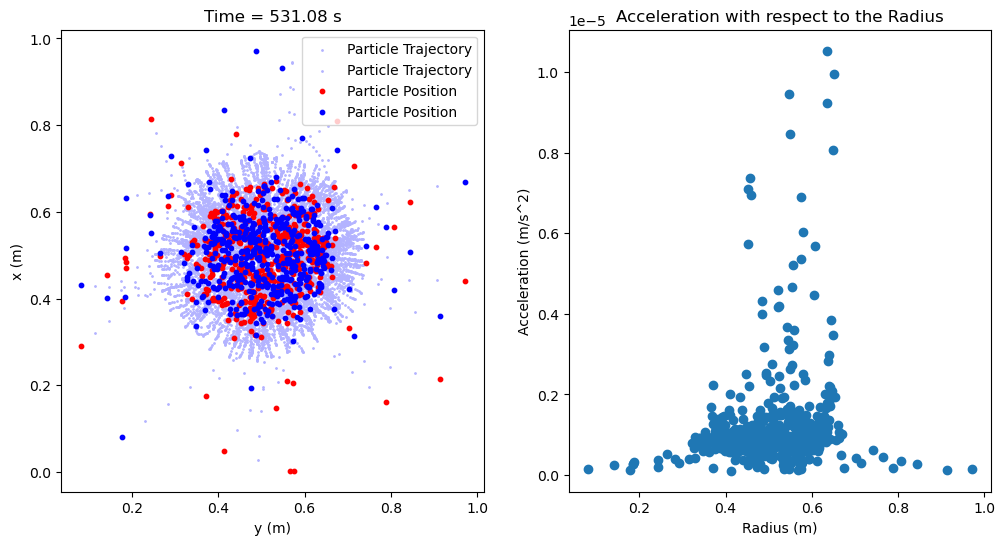

<Figure size 640x480 with 0 Axes>

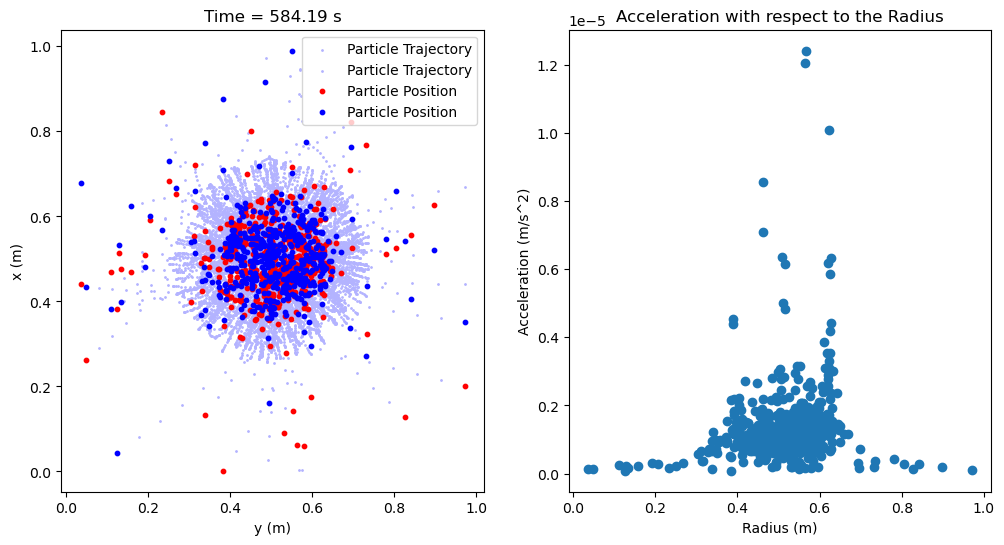

<Figure size 640x480 with 0 Axes>

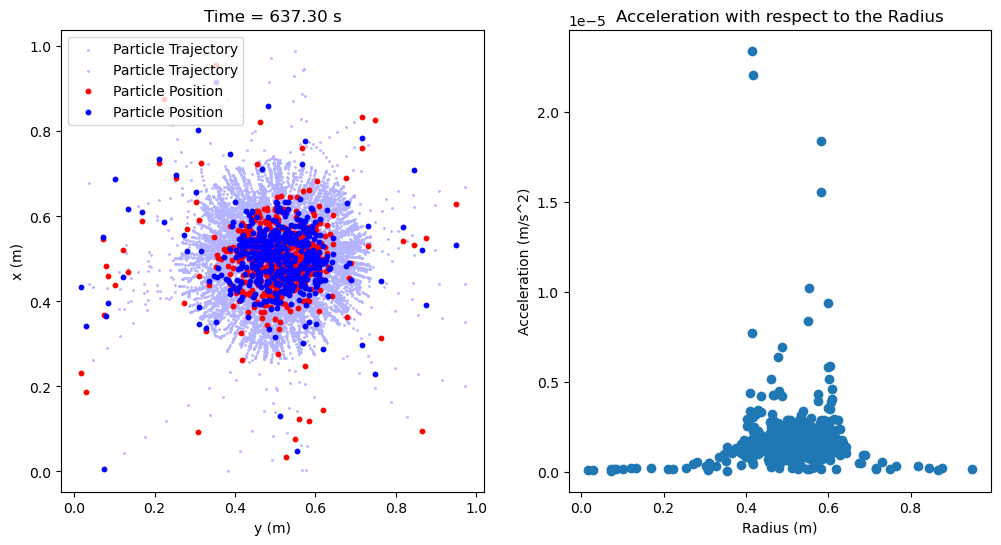

<Figure size 640x480 with 0 Axes>

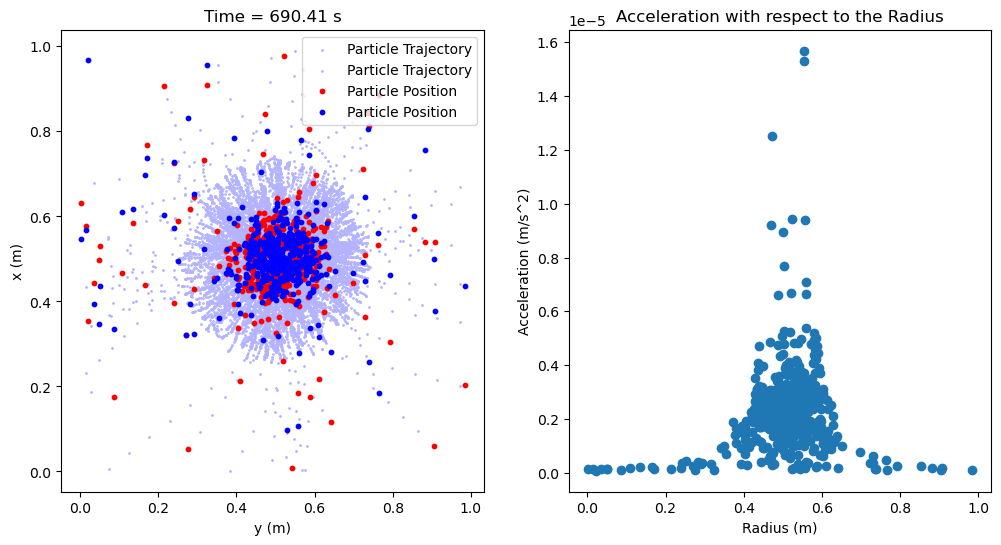

<Figure size 640x480 with 0 Axes>

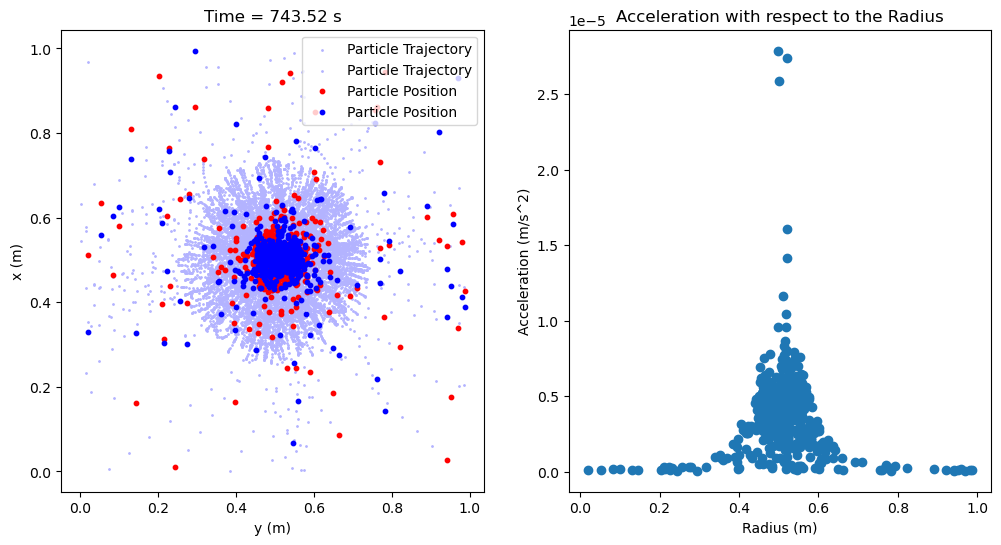

<Figure size 640x480 with 0 Axes>

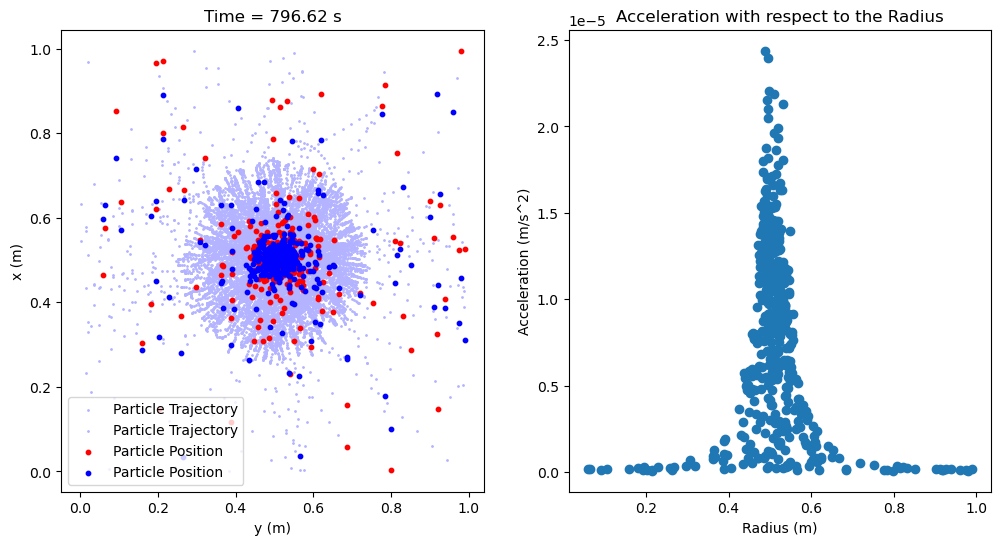

<Figure size 640x480 with 0 Axes>

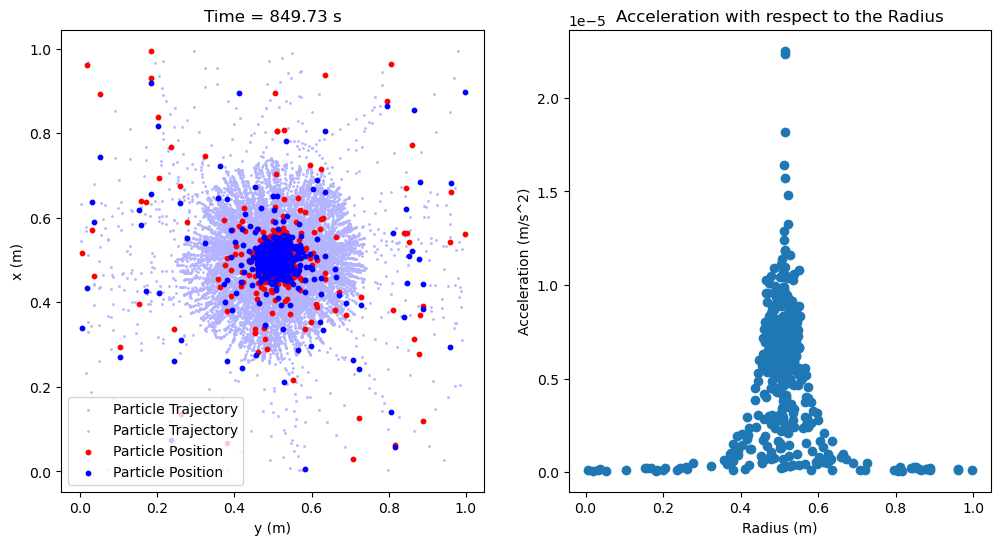

<Figure size 640x480 with 0 Axes>

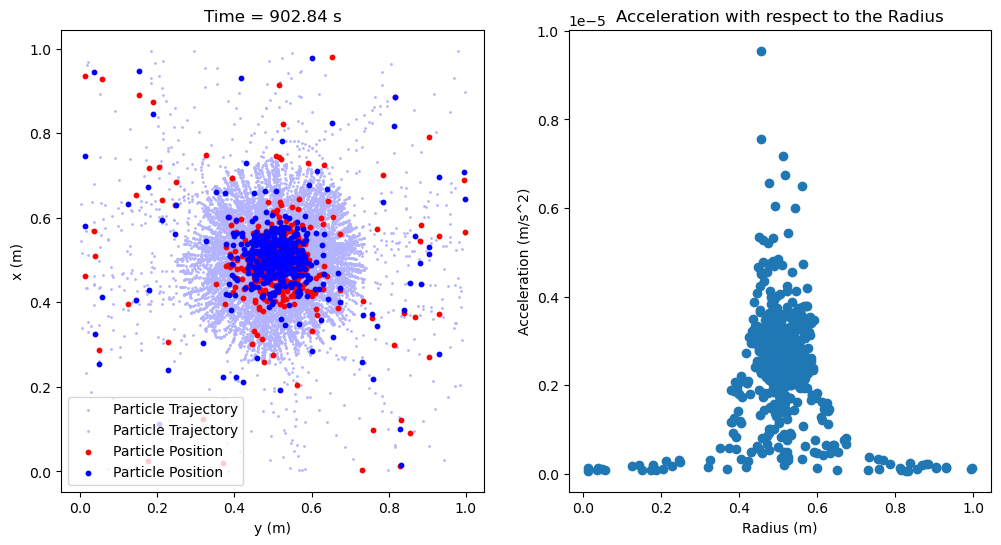

<Figure size 640x480 with 0 Axes>

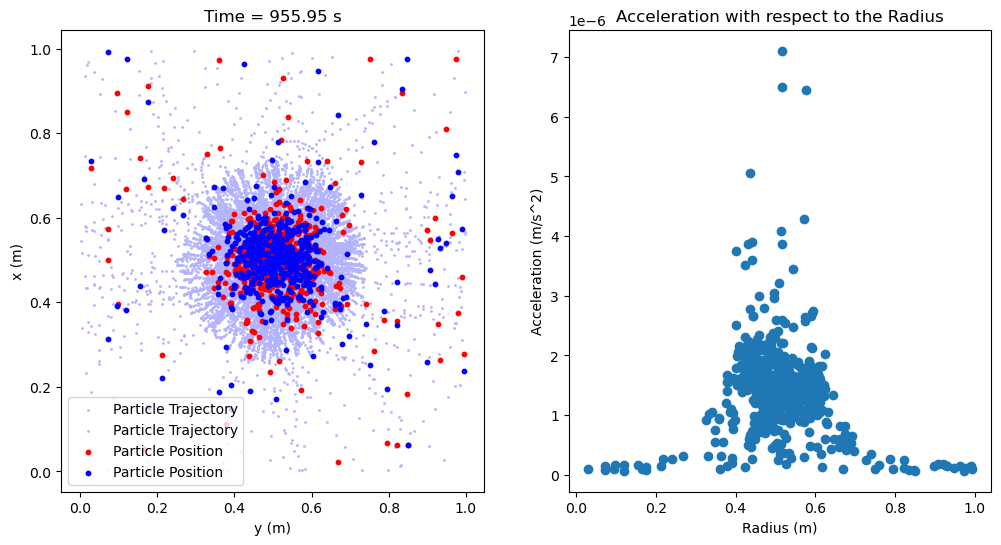

<Figure size 640x480 with 0 Axes>

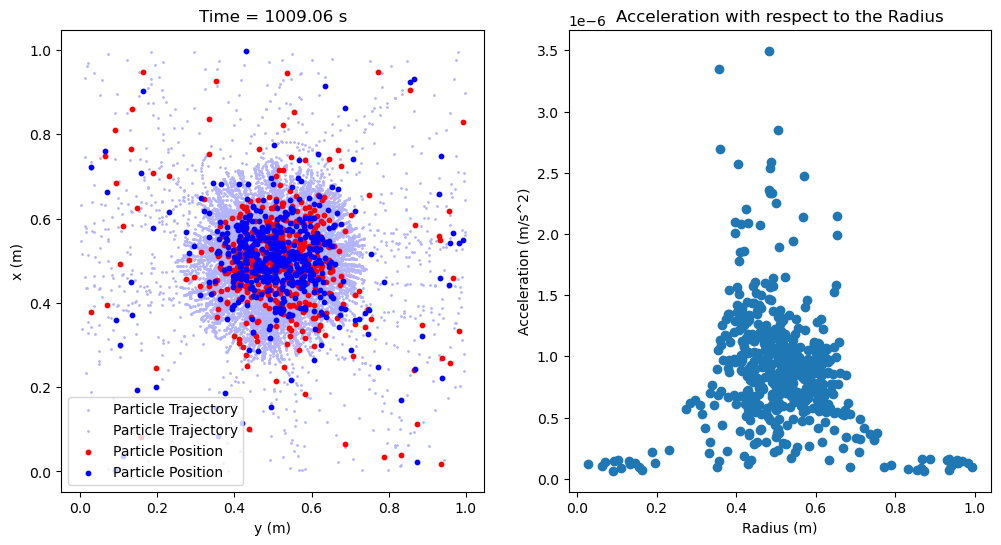

<Figure size 640x480 with 0 Axes>

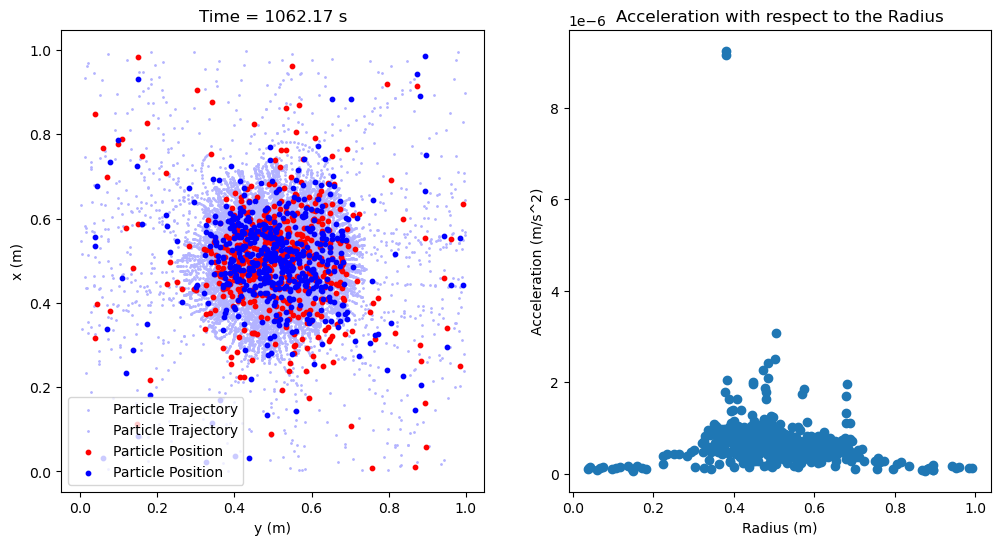

<Figure size 640x480 with 0 Axes>

In [8]:
# input time:
t_max = np.sqrt(np.pi**2 * Rs**3 / (4 * G * Np)) #s # s
factor = 0.0
step = 0.5
Nt = 20 # runs ahead to get the iteration number
mass = np.ones((Np, 1))

# initial conditions:
pos = pos_initial
rho = density_field(pos)
phi = potential_field(rho)
F = cal_force(phi)
# acceleration = cal_acc(F, pos)
acceleration = getAcc(pos, mass, G, softening=1e-3)
velocity = np.zeros((Np, 3))

# add the condition into the particle array:
part[:, 0:3, 0] = pos
part[:, 3:6, 0] = velocity
part[:, 6:9, 0] = acceleration

# Time Integration (KDK with Adaptive Time Step)
time = 0.0
for i in range(Nt):
    # delta time
    dt = t_max/20
    time = time + dt

    # Kick:
    velocity += 0.5 * dt * acceleration

    # Drift:
    pos += dt * velocity
    pos %= L  # Apply periodic boundary conditions

    # Compute new force:
    rho = density_field(pos)
    phi = potential_field(rho)
    F = cal_force(phi)
    # acceleration = cal_acc(F, pos)
    acceleration = getAcc(pos, mass, G, softening=1e-3)

    # Update everthing:
    part[:, 0:3, i+1] = pos
    part[:, 3:6, i+1] = velocity
    part[:, 6:9, i+1] = acceleration

    # Kick:
    velocity += 0.5 * dt * acceleration

    plt.figure(figsize=(12, 6)) 

    # plot in real time
    if plotRealTime or i == Nt-1:
        x = part[:,0,max(i-50,0):i+1]
        y = part[:,1,max(i-50,0):i+1]
        z = part[:,2,max(i-50,0):i+1]

        # First subplot: x vs y
        plt.subplot(1, 2, 1)
        plt.scatter(x, y, s=1, color=[.7, .7, 1], label="Particle Trajectory")
        plt.scatter(x, z, s=1, color=[.7, .7, 1], label="Particle Trajectory")
        plt.scatter(pos[:, 0], pos[:, 2], s=10, color='red', label="Particle Position")
        plt.scatter(pos[:, 0], pos[:, 1], s=10, color='blue', label="Particle Position")
        plt.title(f'Time = {time:.2f} s')
        plt.xlabel('y (m)')
        plt.ylabel('x (m)')
        plt.legend()

        # Second subplot: acceleration vs radius
        plt.subplot(1, 2, 2)
        acc = np.sqrt(acceleration[:,0]**2 + acceleration[:,1]**2 + acceleration[:,2]**2)
        center = [L//2, L//2, L//2]
        r = abs(L//2 - np.sqrt((pos - center)**2))
        plt.plot(r[:,0], acc, 'o')
        plt.title('Acceleration with respect to the Radius')
        plt.xlabel('Radius (m)')
        plt.ylabel('Acceleration (m/s^2)')
        plt.show()

        # Layout:
        plt.tight_layout() 
        plt.pause(0.001)

    # Shouw the plot:
    plt.show()

### Discussions on the results:

#####   The system collapes to it smallest size at around 734.52s. It is before the dynamical time. The reason why cold graviational collapse would happen is because the graviational potential energy of the system that is higher than the system's internal energy, such that for the system, there would be no enough energy to overcome the graviational potential. The second reason why it collapses is that due to the senerio, there's no kinetic energy to resist the graviational force, or increase the speed of the collapsing. The reason why the smallest size of the collapsing happens before the dynamical time is that as the collapsing happens, the particles would experience larger forces due to the decreasing distance. As a result, the particles would be accelerating towards the center of the system.  